In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class sample_random_balls(object):
    
    def __init__(self, n_centers, var_x = 1, var_y = 1, var_xy = 0, x_range = [-10, 10], y_range = [-10, 10], rotate = False):
        """
        Want to sample K blobs, with n_points per blob. Diversity range is controlled by x_range and y_range
        """
        
        self.n_centers = n_centers
        self.covariance = np.array([[var_x, var_xy], 
                                    [var_xy, var_y]])
        
        self.x_centers = np.random.random_sample(n_centers) * (x_range[1] - x_range[0]) + x_range[0]
        self.y_centers = np.random.random_sample(n_centers) * (y_range[1] - y_range[0]) + y_range[0]
        
        self.mu = np.vstack([self.x_centers, self.y_centers]).T
    
    def sample(self, n_points):
        #Find any real matrix A such that A.A^T = Cov. If Cov is positive definite, Cholesky decomposition can be used.
        #Alternatively, use spectral decomposition Cov = U.S.U^(-1) (A = U.sqrt(S)) (U is the eigenvector matrix)
        #Let z = (z_1, ..., z_n)^T be a vector whose components are N independent standard normal variables
        #let x = mu + Az.
        
        #Positive definite - x^T A x > 0 for all x (all eigenvalues are positive)
        #Positive semi-definite - x^T A x >= 0 for all x (all eigenvalues are non-negative)
        
        eig_vals, eig_vect = np.linalg.eig(self.covariance)
        
        if np.sum(eig_vals > 0) == 2:
            print("\nCovariance is positive definite.")
            
            A = np.linalg.cholesky(self.covariance)
            
        elif np.sum(eig_vals >= 0) == 2:
            print("\nCovariance is positive semi-definite.")
            
            A = np.dot(eig_vect, np.diag(np.sqrt(eig_vals)))
        
        point_samples = np.random.randint(low = 0, high = self.n_centers, size = n_points)
        
        z = np.random.randn(n_points, 2)
        x = self.mu[point_samples, :] + np.dot(A, z.T).T
        
        return x, point_samples

In [3]:
class KernelDensity(object):

    def __init__(self, bandwidth = 1.0, bandwidth_type = 'spherical', analytical_optimal = False, kernel = 'gaussian', verbose = False):
        #This implementation is fairly simple and does not use any trees (KDtree or ball tree)
        #More on trees can be found here: 
        #https://towardsdatascience.com/tree-algorithms-explained-ball-tree-algorithm-vs-kd-tree-vs-brute-force-9746debcd940
        #I also only implement a Gaussian kernel with 
        self.bandwidth = bandwidth
        self.bandwidth_type = bandwidth_type
        self.analytical_optimal = analytical_optimal
        self.kernel = kernel
        self.verbose = verbose
        
        if kernel.lower() == 'gaussian':
            self.kernel = self.gaussian_kernel
        
        else:
            print("No other kernels implemented.")
            raise SystemExit
        
    def initialise_H(self, X):
        
        N, d = X.shape
        
        if self.bandwidth_type.lower() == 'spherical':
            self.H = np.diag(np.ones(d) * self.bandwidth)
        
        elif self.bandwidth_type.lower() == 'diagonal':
            
            if self.analytical_optimal:
                
                print("Computing analytical diagonal bandwidths!")
                
                cov_mat = np.cov(X, rowvar = False)
                
                diagE = np.diag(cov_mat)
                H_diag = N**(-1 / (d + 4)) * np.sqrt(diagE)
                
                self.H = np.diag(H_diag)
            
            else:
                print("Diagonal bandwidth is the same as the spherical.")
                self.H = np.diag(np.ones(d) * self.bandwidth)
                
        
        elif self.bandwidth_type.lower() == 'full':
            if self.analytical_optimal:
                
                print("Computing analytical full bandwidths!")
                
                #Use eigenvector/eigenvalue approach to compute E**(1/2) (SVD for now as cov is symmetric)
                #For future reference, using the Eigenvals and eigenvectors 
                cov_mat = np.cov(X, rowvar = False)
                
                #Method 1
                #eigval, eigvect = np.linalg.eig(cov_mat)
                #Cov_new = np.zeros_like(cov_mat)
                #for i in range(len(eigval)):
                #    Cov_new += eigval[i]**(1/2) * np.outer(eigvect[:, i], eigvect[:, i])
                
                #Method 2
                u, s, vT = np.linalg.svd(cov_mat)
                S = np.diag(s**(1/2)) #Scale by 1/2
                
                Cov_new = np.dot(u, np.dot(S, vT))
                
                self.H = N**(-1 / (d + 4)) * Cov_new
            
            else:
                print("Assumption is that the bandwidth entered is already a matrix.")
                self.H = self.bandwidth
        
        else:
            print("Invalid bandwidth type entered.")
            raise SystemExit
    
    def standard_gaussian_kernel(self, u, log_flag):
        d = u.shape[0]
        
        product = np.dot(u.T, u)
        
        if log_flag:
            gauss = - d/2 * np.log(2 * np.pi) - 1/2 * product
        
        else:
            gauss = 1/( (2 * np.pi)**(d/2) ) * np.exp(-1/2 * product)
        
        return gauss[0, 0]
    
    def gaussian_kernel(self, x, xi, log_flag):
        
        u = x - xi
        Hu = np.linalg.solve(self.H, u)
        detH = np.linalg.det(self.H)
        
        if log_flag:
            Kout = self.standard_gaussian_kernel(Hu, log_flag) - np.log(detH)
        
        else:
            Kout = self.standard_gaussian_kernel(Hu, log_flag) / detH

        return Kout
    
    def fit(self, X):
        
        print("\nInitialising the bandwidth matrix...")
        self.initialise_H(X)
        
        print("Fitting data...")
        self.Xdata = X
        
        print("Done!")
        return self
        
    def calculate_likelihood(self, Xi, log_flag):
        
        N, d = self.Xdata.shape
        
        likelihood = []
        
        for i in range(N):
            
            x = self.Xdata[i, :].reshape(-1, 1)
            
            likelihood.append(self.kernel(x, Xi, log_flag))
        
        aj = np.array(likelihood)
        
        if log_flag:
            A = np.max(aj)
            
            sum_exp = np.sum(np.exp(aj - A))
            log_sum_exp = A + np.log(sum_exp)
            
            output = - np.log(N) + log_sum_exp
        
        else:
            output = np.sum(aj) / N
        
        return output
    
    def score_samples(self, X, log_flag = False):
        
        print("\nScoring samples...\n")
        pred = []
        
        for i in range(X.shape[0]):
            
            Xi = X[i, :].reshape(-1, 1)
            
            pred.append(self.calculate_likelihood(Xi, log_flag))
            
            if self.verbose:
                print("Scored sample {}".format(i + 1))
                
        return np.array(pred)
    


(200, 1)


<IPython.core.display.Javascript object>


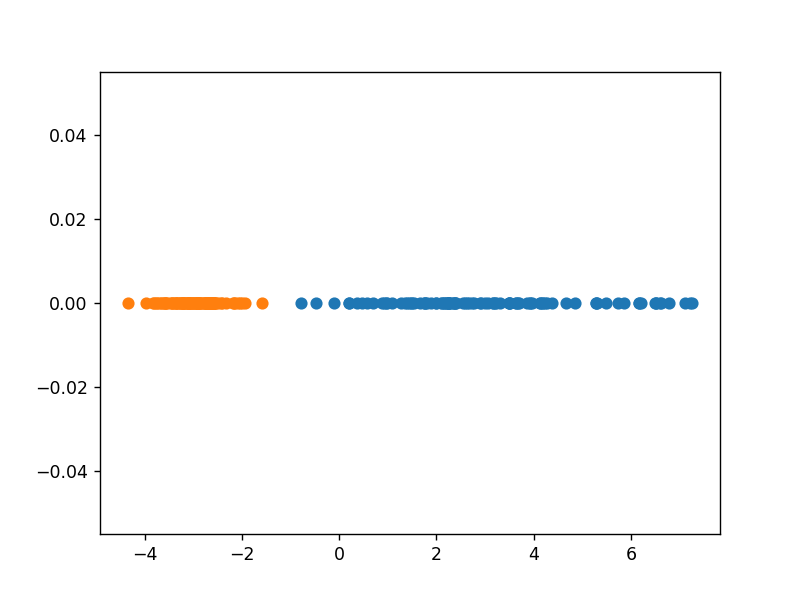


Initialising the bandwidth matrix...
Fitting data...
Done!

Scoring samples...


Scoring samples...



<IPython.core.display.Javascript object>


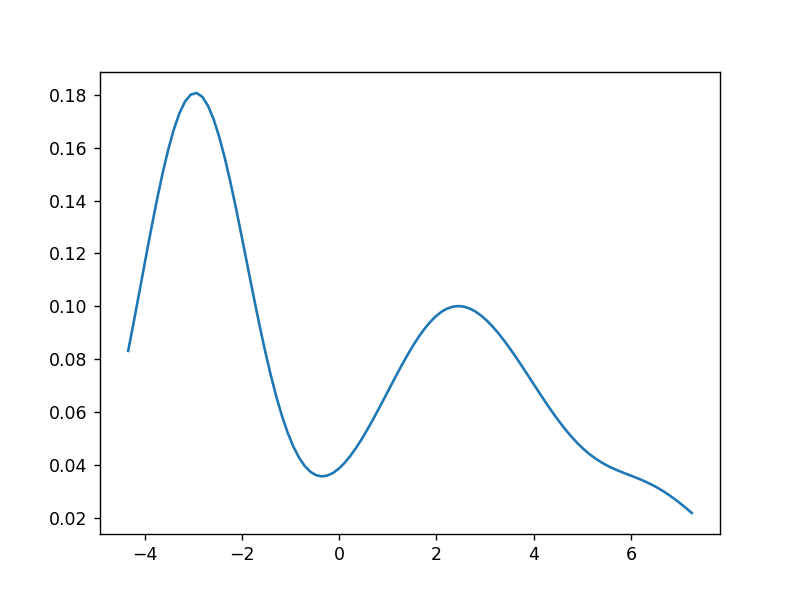

<IPython.core.display.Javascript object>


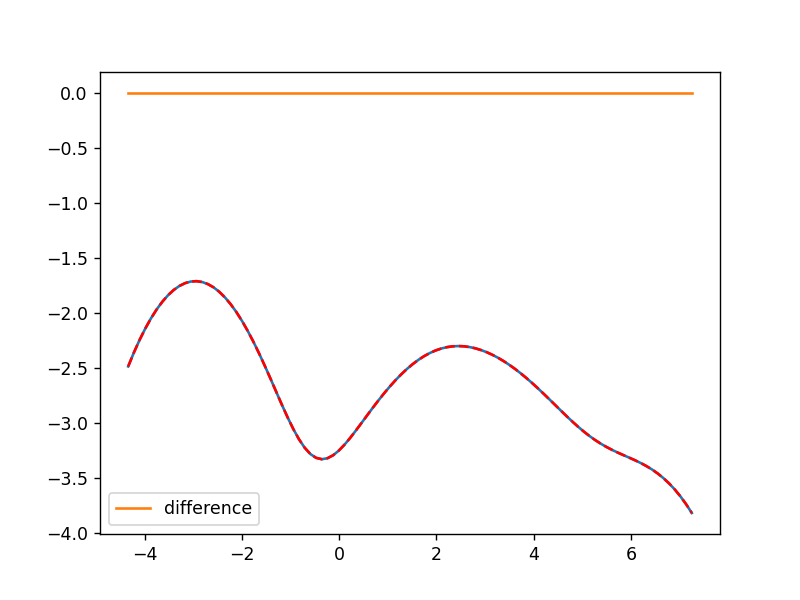

<function matplotlib.pyplot.show(block=None)>

In [4]:
%matplotlib notebook

test_KDE = KernelDensity(bandwidth = 1)

x1 = np.random.randn(100, 1) * 2 + 3
x2 = np.random.randn(100, 1) * 0.5 - 3

x = np.vstack((x1, x2))
print(x.shape)

plt.figure()
plt.scatter(x1, np.zeros_like(x1))
plt.scatter(x2, np.zeros_like(x2))
plt.show()

test_KDE.fit(x)

x_new = np.linspace(np.min(x), np.max(x), 100).reshape(-1, 1)

pred1 = test_KDE.score_samples(x_new, log_flag = False)
pred2 = test_KDE.score_samples(x_new, log_flag = True)

plt.figure()
plt.plot(x_new[:, 0], pred1)
plt.show

plt.figure()
plt.plot(x_new[:, 0], pred2)
plt.plot(x_new[:, 0], np.log(pred1), "r--")
plt.plot(x_new[:, 0], pred2 - np.log(pred1), label = 'difference')
plt.legend()
plt.show

[[1.  0.8]
 [0.8 1. ]]


<IPython.core.display.Javascript object>


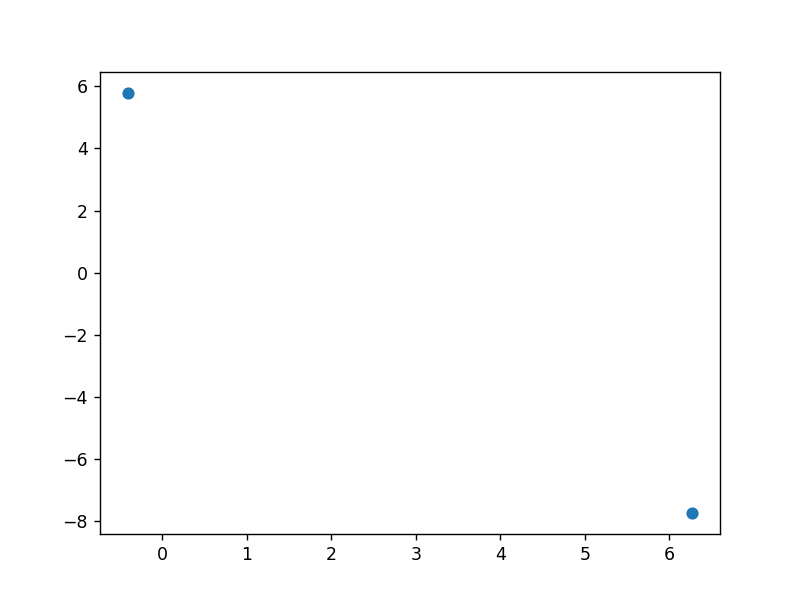


Covariance is positive definite.
(1000, 2)


<IPython.core.display.Javascript object>


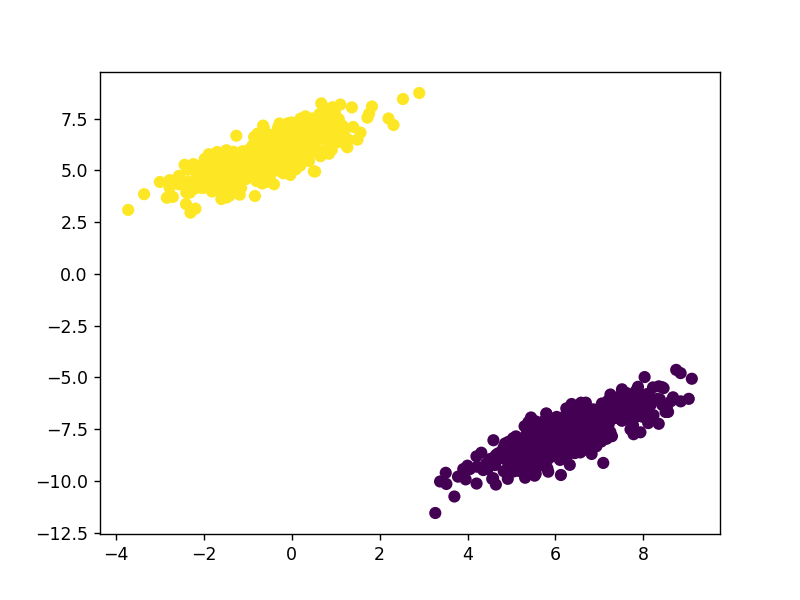

In [5]:
sample_blobs = sample_random_balls(2, var_x = 1, var_y = 1, var_xy = 0.8)
print(sample_blobs.covariance)
plt.figure()
plt.scatter(sample_blobs.mu[:, 0], sample_blobs.mu[:, 1])
plt.show()

x, l = sample_blobs.sample(1000)

print(x.shape)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()


Initialising the bandwidth matrix...
Diagonal bandwidth is the same as the spherical.
Fitting data...
Done!

Scoring samples...


Scoring samples...



<IPython.core.display.Javascript object>


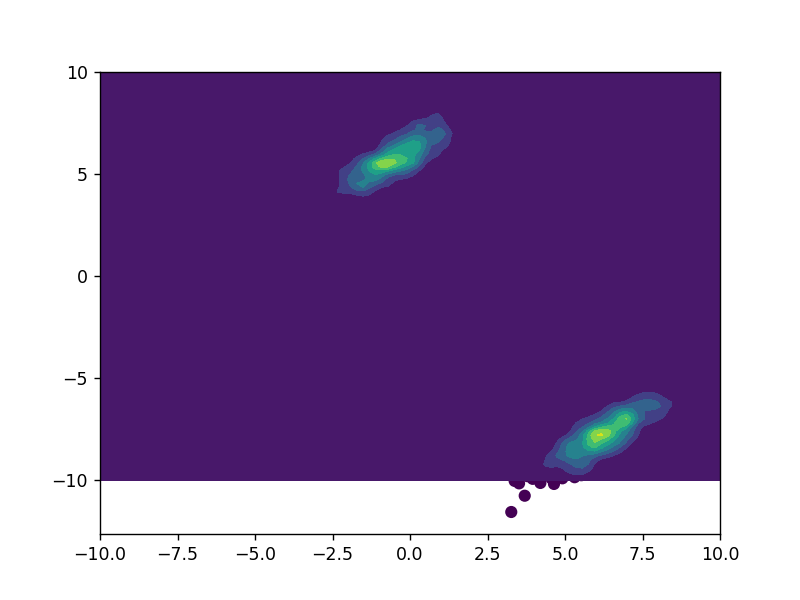

<IPython.core.display.Javascript object>


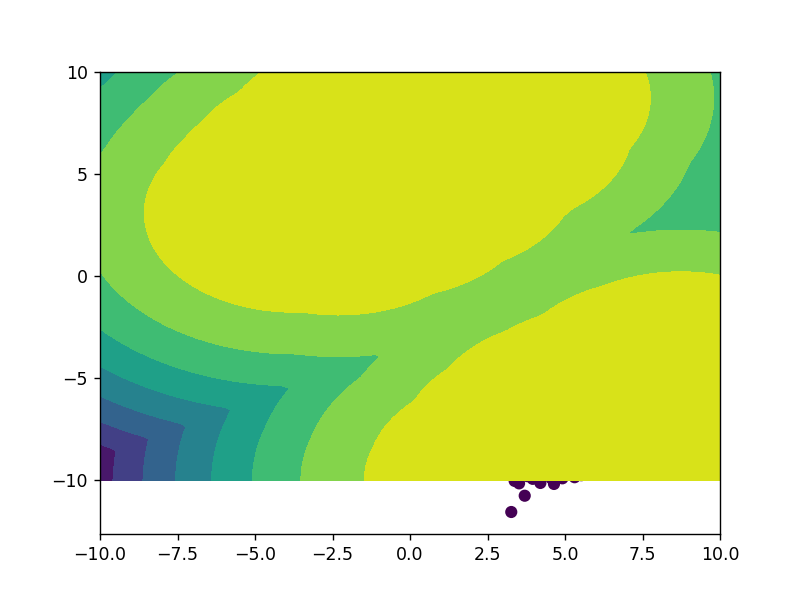

In [6]:
test_KDE = KernelDensity(bandwidth = 0.2, bandwidth_type = 'diagonal', analytical_optimal = False)

test_KDE.fit(x)

X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
XY = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))

Z1 = test_KDE.score_samples(XY, log_flag = False)
Z2 = test_KDE.score_samples(XY, log_flag = True)


plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.contourf(X, Y, Z1.reshape(100, 100))
plt.show()


plt.figure()
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.contourf(X, Y, Z2.reshape(100, 100))
plt.show()


Initialising the bandwidth matrix...
Computing analytical diagonal bandwidths!
Fitting data...
Done!

Scoring samples...


Scoring samples...



<IPython.core.display.Javascript object>


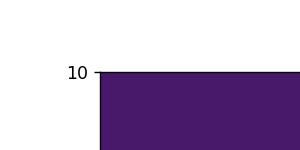

<IPython.core.display.Javascript object>


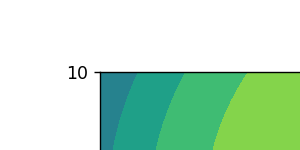

In [7]:
test_KDE = KernelDensity(bandwidth = 0.2, bandwidth_type = 'diagonal', analytical_optimal = True)

test_KDE.fit(x)

X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
XY = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))

Z3 = test_KDE.score_samples(XY, log_flag = False)
Z4 = test_KDE.score_samples(XY, log_flag = True)


plt.figure()
plt.contourf(X, Y, Z3.reshape(100, 100))
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()


plt.figure()
plt.contourf(X, Y, Z4.reshape(100, 100))
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()


Initialising the bandwidth matrix...
Computing analytical full bandwidths!
Fitting data...
Done!

Scoring samples...


Scoring samples...



<IPython.core.display.Javascript object>


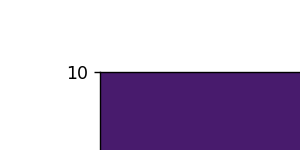

<IPython.core.display.Javascript object>


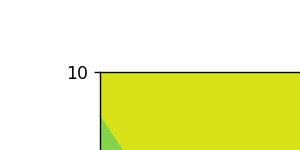

In [8]:
test_KDE = KernelDensity(bandwidth = 0.2, bandwidth_type = 'full', analytical_optimal = True)

test_KDE.fit(x)

X, Y = np.meshgrid(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100))
XY = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))

Z5 = test_KDE.score_samples(XY, log_flag = False)
Z6 = test_KDE.score_samples(XY, log_flag = True)


plt.figure()
plt.contourf(X, Y, Z5.reshape(100, 100))
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()


plt.figure()
plt.contourf(X, Y, Z6.reshape(100, 100))
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

In [9]:
h = 2
d = 5
N = 1

x1 = np.zeros((d, 1))
x2 = np.ones((d, 1))

a1 = 1/(2 * np.pi * h**2)**(d/2) * np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * h**2))

u = x1 - x2
H = np.diag(np.array([h] * 5))

detH = np.linalg.det(H)
Hu = np.linalg.solve(H, u)
a2 =1/((2 * np.pi)**(d/2) * detH) * np.exp(-1/2 * np.dot(Hu.T, Hu))

print(a1, a2, a1 - a2)

0.00016903097618134163 [[0.00016903]] [[-5.42101086e-20]]


In [10]:
from sklearn.neighbors import KernelDensitySKL
import numpy as np
rng = np.random.RandomState(42)

kde = KernelDensitySKL(kernel='gaussian', bandwidth=1, ).fit(x)
log_density = kde.score_samples(XY)

plt.figure()
plt.contourf(X, Y, log_density.reshape(100, 100))
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

plt.figure()
plt.contourf(X, Y, np.exp(log_density.reshape(100, 100)))
plt.scatter(x[:, 0], x[:, 1], c = l)
plt.show()

ImportError: cannot import name 'KernelDensitySKL' from 'sklearn.neighbors' (C:\Users\ryanb.LAPTOP-4EHB9TVB\anaconda3\lib\site-packages\sklearn\neighbors\__init__.py)

In [ ]:
Cov = np.cov(x, rowvar = False)

print(Cov)

eigval, eigvect = np.linalg.eig(Cov)

print(eigval)
print(eigvect)

Cov_new = np.zeros_like(Cov)

for i in range(len(eigval)):
    Cov_new += eigval[i]**(-1) * np.outer(eigvect[:, i], eigvect[:, i])

print(Cov_new)

print(np.linalg.inv(Cov) - Cov_new)

In [ ]:
u, s, vh = np.linalg.svd(Cov)


print(np.dot(u, np.dot(np.diag(s**-1), vh)))